# Análise exploratória de preços do Binance Coin (BNB/USDT)

Descrição resumida
- Script em Python para baixar OHLCV do par BNBUSDT da API da Binance, limpar e preparar os dados, calcular métricas/indicadores simples e gerar visualizações exploratórias.
- Etapas implementadas: coleta, limpeza, estatísticas descritivas, visualizações, correlação e feature engineering (médias móveis e volatilidade).

Dependências
- requests
- pandas
- numpy
- matplotlib
- seaborn

Instalação (exemplo)
```bash
pip install requests pandas numpy matplotlib seaborn
```

Principais funções/variáveis
- get_binance_ohlc(symbol="BNBUSDT", interval="1d", start=1493596800000, end=None)
    - Baixa candles (klines) da Binance e retorna DataFrame com colunas convertidas (datas e numéricos).
    - Parâmetro start em milissegundos (default começa em 2017).
- BNB_df
    - DataFrame final filtrado para ["open_time", "open", "high", "low", "close", "volume"] e ordenado por data.
    - Colunas adicionadas: `return` (pct_change), `SMA_7`, `SMA_30`, `volatilidade_7d`.

Outputs / Visualizações geradas
- Série temporal do preço de fechamento.
- Gráfico de volume diário.
- Histograma + KDE da distribuição dos retornos diários.
- Heatmap da matriz de correlação entre variáveis.
- Gráfico do preço com médias móveis (7d e 30d).
- Estatísticas descritivas impressas e contagem de linhas analisadas.

Observações importantes
- Requer conexão com a internet e acesso à API pública da Binance.
- Atenção a limites de taxa da API; para séries longas pagine chamadas ou implemente cache.
- O start padrão (1493596800000) é em ms; ajuste para período desejado.
- Valores NaN aparecem nas primeiras linhas ao calcular médias móveis e retornos (comportamento esperado).

Melhorias sugeridas
- Salvar o DataFrame em CSV/Parquet para análises futuras e evitar múltiplas chamadas.
- Implementar tratamento de exceções mais robusto e retry/backoff para requisições.
- Adicionar normalização, features adicionais (RSI, MACD) e pipeline para modelagem/forecast.
- Incluir argumentos CLI ou widgets para escolher período, símbolo e intervalo.

Licença
- Livre para uso/ajuste (adapte conforme necessidade do projeto).

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# COLETA DE DADOS
# ==============================
def get_binance_ohlc(symbol="BNBUSDT", interval="1d",
                      start=1493596800000, end=None):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "startTime": start, "endTime": end}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "quote_volume", "num_trades",
            "taker_base_vol", "taker_quote_vol", "ignore"]

    df = pd.DataFrame(data, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df[["open", "high", "low", "close", "volume"]] = \
        df[["open", "high", "low", "close", "volume"]].astype(float)

    return df


# Baixar histórico do BNB para 2024
BNB_df = get_binance_ohlc("BNBUSDT")

In [2]:
# ==============================
# LIMPEZA E PREPARAÇÃO
# ==============================
# Remover colunas desnecessárias
BNB_df = BNB_df[["open_time", "open", "high", "low", "close", "volume"]]

# Verificar valores nulos
print("Valores nulos:\n", BNB_df.isna().sum())

# Garantir que está ordenado por data
BNB_df = BNB_df.sort_values("open_time").reset_index(drop=True)

# Adicionar uma coluna de 'retorno diário'
BNB_df["return"] = BNB_df["close"].pct_change()

Valores nulos:
 open_time    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


In [3]:
# ==============================
# ESTATÍSTICAS DESCRITIVAS
# ==============================
print("\nResumo estatístico dos preços:")
print(BNB_df[["open", "high", "low", "close", "volume", "return"]].describe())


Resumo estatístico dos preços:
             open        high         low       close        volume  \
count  500.000000  500.000000  500.000000  500.000000  5.000000e+02   
mean     9.975696   10.442020    9.443894   10.005945  2.056956e+06   
std      4.031501    4.250125    3.793390    4.021951  1.511178e+06   
min      1.500000    1.576500    0.500000    1.490000  9.198649e+04   
25%      6.772000    7.173700    6.471925    6.846300  9.644992e+05   
50%      9.977000   10.356950    9.675150    9.986100  1.615956e+06   
75%     13.016050   13.633325   12.247650   13.016875  2.739153e+06   
max     22.600000   25.180000   21.040000   22.600000  9.971697e+06   

           return  
count  499.000000  
mean     0.007370  
std      0.078285  
min     -0.317483  
25%     -0.028505  
50%      0.000553  
75%      0.035818  
max      0.628656  


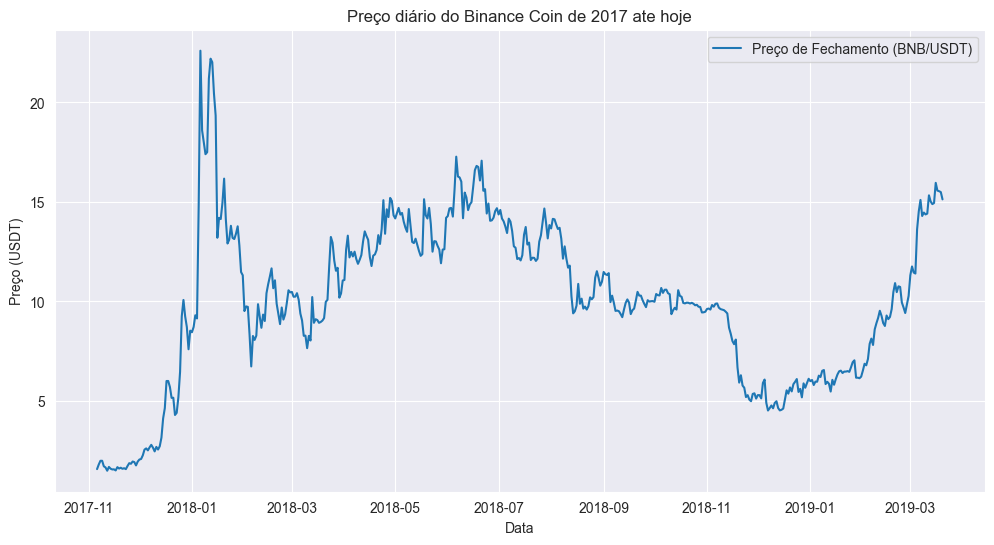

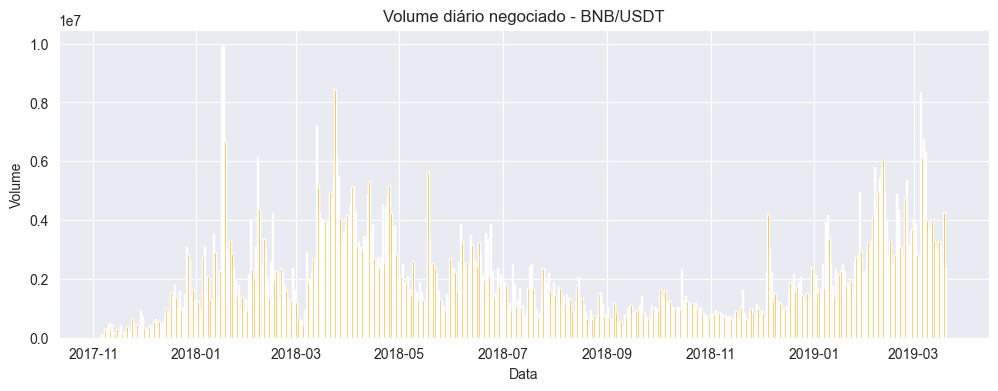

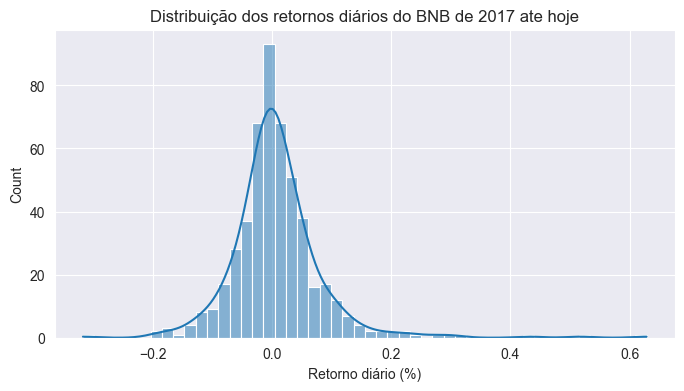

In [4]:
# ==============================
# VISUALIZAÇÕES EXPLORATÓRIAS
# ==============================
plt.figure(figsize=(12,6))
plt.plot(BNB_df["open_time"], BNB_df["close"], label="Preço de Fechamento (BNB/USDT)")
plt.title("Preço diário do Binance Coin de 2017 ate hoje")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()

# Volume negociado
plt.figure(figsize=(12,4))
plt.bar(BNB_df["open_time"], BNB_df["volume"], color="orange")
plt.title("Volume diário negociado - BNB/USDT")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.show()

# Distribuição dos retornos
plt.figure(figsize=(8,4))
sns.histplot(BNB_df["return"].dropna(), bins=50, kde=True)
plt.title("Distribuição dos retornos diários do BNB de 2017 ate hoje")
plt.xlabel("Retorno diário (%)")
plt.show()


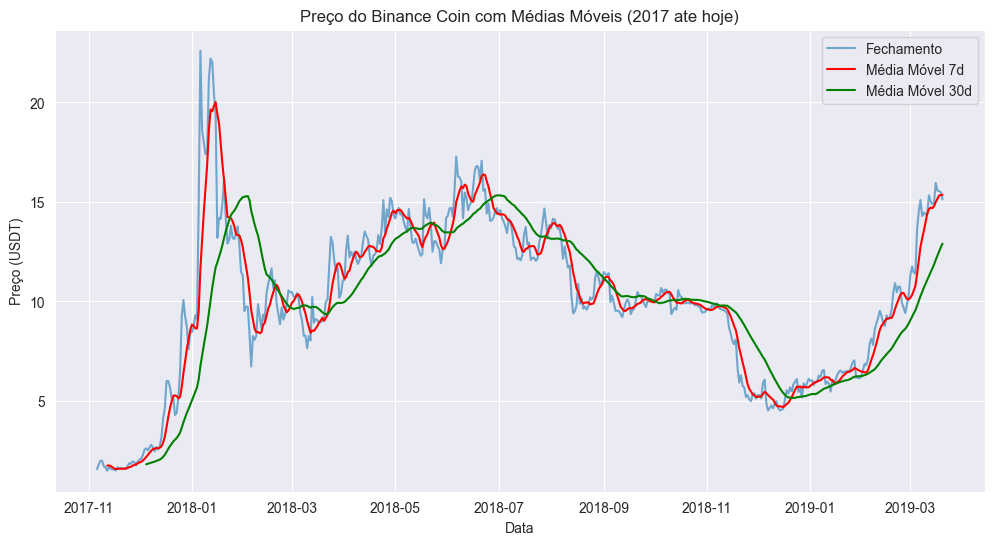

In [5]:
# ==============================
# FEATURE ENGINEERING (para predição futura)
# ==============================
# Médias móveis (tendência)
BNB_df["SMA_7"] = BNB_df["close"].rolling(window=7).mean()   # 1 semana
BNB_df["SMA_30"] = BNB_df["close"].rolling(window=30).mean() # 1 mês

# Volatilidade (desvio padrão dos retornos)
BNB_df["volatilidade_7d"] = BNB_df["return"].rolling(window=7).std()

# Gráfico com médias móveis
plt.figure(figsize=(12,6))
plt.plot(BNB_df["open_time"], BNB_df["close"], label="Fechamento", alpha=0.6)
plt.plot(BNB_df["open_time"], BNB_df["SMA_7"], label="Média Móvel 7d", color="red")
plt.plot(BNB_df["open_time"], BNB_df["SMA_30"], label="Média Móvel 30d", color="green")
plt.title("Preço do Binance Coin com Médias Móveis (2017 ate hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# ==============================
# Resultado final
# ==============================
print("Análise exploratória concluída com sucesso!")
print("Linhas analisadas:", len(BNB_df))
BNB_df.tail()


Análise exploratória concluída com sucesso!
Linhas analisadas: 500


,open_time,open,high,low,close,volume,return,SMA_7,SMA_30,volatilidade_7d
495,2019-03-16,14.9429,16.0000,14.880,15.9589,3293876.13,0.067971,14.990757,12.087583,0.035887
496,2019-03-17,15.9589,15.9589,15.440,15.5693,3106901.48,-0.024413,15.161929,12.296857,0.038212
497,2019-03-18,15.5836,15.7888,15.204,15.5388,2472584.89,-0.001959,15.322571,12.511193,0.038455
498,2019-03-19,15.5361,15.8000,15.000,15.4953,4271050.40,-0.002799,15.345714,12.720370,0.030825
499,2019-03-20,15.5098,15.5098,15.022,15.1288,2369648.38,-0.023652,15.360629,12.904240,0.031268
